In [243]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import sklearn
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import warnings
warnings.filterwarnings('ignore')
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor

r = np.random.RandomState(1234)

# Simulating supervised learning methodologies as an intervention for adverse impact in hiring with biased selection tools

## Problem
Effective hiring tools select minorities at lower rates than majorities, making them not effective and unuasable. To talk about this problem, I'm going to introduce a few organizational psychology concepts.

The tools used to hire employees are considered valid if they predict some job relevant criteria- most often job performance. The relationship between a hiring tool and the criterion is called *predictive validity*. Generally this is just the correlation between scores from the tool and the criterion.

The proprtion of minority applicants selected to majority applicants is called an *impact ratio*. When a selection tool results in a higher proportion of the majority being selected than the minority it's said to have *disparate impact*. If the entire selection process selects a higher proportion of the majority than the minority, it's said to have *adverse impact*. Legally, if the impact ratio is less than .8 the process has adverse impact and employers can be held liable for discrimination (subject to a whole bunch of other stuff of course, but .8 is the rule).

An example impact ratio caclulation:
minority applicants= 30
minority hires= 5
majority applicants= 100
majority hires = 20

(5/30)/(20/100) = 0.83 which is above the .8 legal threshold for adverse impact.

If you're thinking this is a poor system for identifying discrimatory hiring process, you're correct. Statistical significance is not even considered. Because hiring decisions are such high stakes and can result in legal action, statistical validity is not the priority. The field neccesarily moves slow because it depends on prior case law to ensure valid methods are being used. Thus, we are stuck with the impact ratio.

This project attempts to investigate using non-parametric methodologies to minimize impact ratio while still prioritizing validity. In practice, minority group is not used as an attribute in creating hiring models. Minority data is both hard to come by, but also using it in hiring could put employers in danger because minority status is not job relevant. Thus, predicting job performance still has to be our dependedent variable. However, we will be evaluating models based on the impact ratio observed in the test dataset as well as accuracy and f1 scores. 

The reason I think using non-parametric methods could result in lower impact ratios is because the allow for more than one path to success. So if a hiring tool has disparate impact while others do not, minorities could still be hired by performing well in the tools without disparate impact.

## About the data
This is a simulated dataset I created based on metaanlytic correlations and effect sizes for black-white subgroups for each attribute. The literature and script can be found in the github repository. https://github.com/SarahMcEliece/DTSA-5509-Supervised-Learning


## EDA
In this case, exploaratory data analysis is largely unnecesary since this is a dataset I constructed based on a literature review. I'll use it to better frame the issue though.

In [2]:
#my dataset created in _url_
data = pd.read_csv('sim_AI_dataset.csv')

In [3]:
data.info()
#no missing values, all variables are numerical. 'group' is categorical

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115607 entries, 0 to 115606
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            115607 non-null  int64  
 1   Cognitive Ability     115607 non-null  float64
 2   Education             115607 non-null  float64
 3   Experience            115607 non-null  float64
 4   Structured Interview  115607 non-null  float64
 5   Conscientiousness     115607 non-null  float64
 6   Performance           115607 non-null  float64
 7   group                 115607 non-null  int64  
dtypes: float64(6), int64(2)
memory usage: 7.1 MB


In [4]:
#dropping the previous index
data.drop('Unnamed: 0', inplace=True, axis=1)

When building a model to select employees the must common predictor variable is job performance. Other variables like turnover can be used, but it is less common and there is less literature. When I talk about prediction in this project, I am referring to predicting job performance.

We have 5 predictor variables. I'll discuss each in turn. All relationships between performance and predictors are based on metaanlytic correlations in Schmidt et al. 2016, I'll put this in my gitlab project if you're interested.

Because this is simulated data and all of these variables can be measured on many different scales, I arbitrarily set the population mean=5 and standard deviation=1 for the majority group, then derived the minority population means based on effect sizes documented in the literature. 

In [5]:
data.describe()

,Cognitive Ability,Education,Experience,Structured Interview,Conscientiousness,Performance,group
count,115607.000000,115607.000000,115607.000000,115607.000000,115607.000000,115607.000000,115607.000000
mean,4.902005,5.003377,4.999242,4.958947,5.001836,4.999381,0.135000
std,1.026321,0.999443,0.999285,1.006065,1.000797,0.999905,0.341726
min,0.389816,0.828278,0.454884,0.691540,0.683809,0.754481,0.000000
25%,4.216413,4.332148,4.325475,4.283136,4.327850,4.327340,0.000000
50%,4.906598,5.003464,4.996693,4.962317,4.999604,4.999057,0.000000
75%,5.594606,5.674798,5.673516,5.635715,5.672197,5.675267,0.000000
max,9.205868,9.408120,9.106481,9.127501,9.775769,9.397566,1.000000


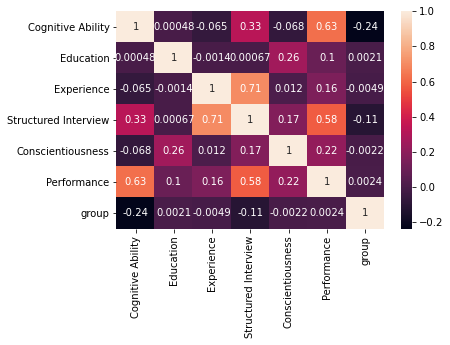

In [6]:
sn.heatmap(data.corr(),annot=True)

#### Cognitive ability
Cognitive ability is the best predictor of job performance we have across the board. It has a .65 correlation with performance. In social science research a relationship that strong is exteremely rare. However, selecting on cognitive ability results in disparate impact especially between white and black subgroups. This means that if we only use cognitive ability to choose who to hire, a higher percentage of white applicants will be hired than black applicants. Generally, it is debated whether the cause of the subgroup differences are because cognitive ability is less predicitive for blacks than for whites(called differential validity) or if it is an simply an artifcat of range restriction in the applicant pool. A effect size of up to 1.0 is often observed, in this project I used .72 which was taken from the literature. The minority population(group=1) is 13.4% of the overall population which is the percentage of the US population that is black.

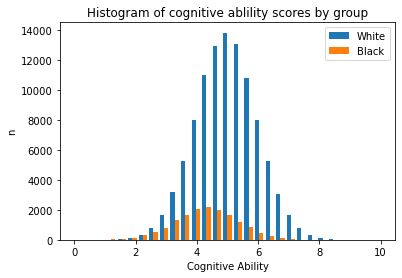

In [7]:
bins = np.linspace(0, 10, 30)
plt.hist([data[data['group']==0]['Cognitive Ability'], data[data['group']==1]['Cognitive Ability']], bins, label=['White', 'Black'])
plt.legend(loc='upper right')
plt.title('Histogram of cognitive ablility scores by group')
plt.ylabel('n')
plt.xlabel('Cognitive Ability')
plt.show()

#### Education and Experience
Education and experience both are very weak predictors of job performance (r=.1 and r=.16 respectively), yet are very commonly used in hiring which is why I included them in my model. I could not find documentented sub-group differences, so I set the effect size for both as 0. These variables are on the same continuous scale as our other predictors, but how they are measured in practice varies. Sometimes they become categorical variables like 'High school diploma', or number of years of education, etc.

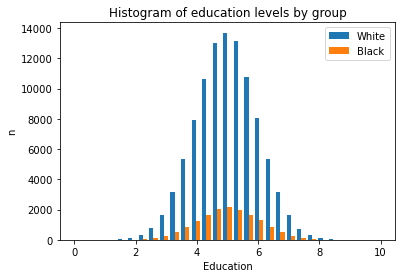

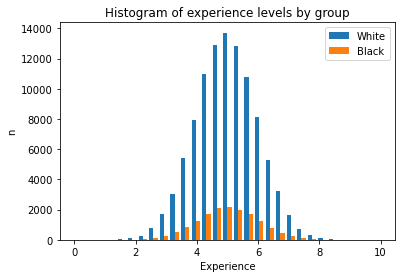

In [8]:
bins = np.linspace(0, 10, 30)
plt.hist([data[data['group']==0]['Education'], data[data['group']==1]['Education']], bins, label=['White', 'Black'])
plt.legend(loc='upper right')
plt.title('Histogram of education levels by group')
plt.ylabel('n')
plt.xlabel('Education')
plt.show()

bins = np.linspace(0, 10, 30)
plt.hist([data[data['group']==0]['Experience'], data[data['group']==1]['Experience']], bins, label=['White', 'Black'])
plt.legend(loc='upper right')
plt.title('Histogram of experience levels by group')
plt.ylabel('n')
plt.xlabel('Experience')
plt.show()

#### Structured Interview
A structured interview is essentially an interview with rules placed around it to try and create a similar experience for each candidate. The level of structure can vary- candidataes can all be asked the same set of questions, scoring can be done based on a rubric with anchored scores. Highly structured interviews tend to be less biased and more predictive than unstructured interviews. Yet both interviewers and interviewees tend to dislike them. Sturctured interviews have good predictive validity (r=0.58) yet also have score differnces between white and black subgroups (d=0.31).

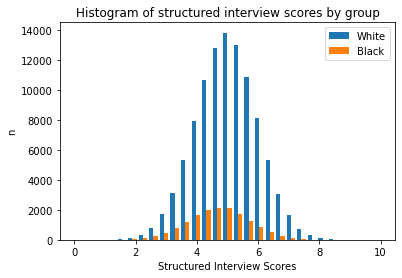

In [9]:
bins = np.linspace(0, 10, 30)
plt.hist([data[data['group']==0]['Structured Interview'], data[data['group']==1]['Structured Interview']], bins, label=['White', 'Black'])
plt.legend(loc='upper right')
plt.title('Histogram of structured interview scores by group')
plt.ylabel('n')
plt.xlabel('Structured Interview Scores')
plt.show()

#### Conscientiousness
Conscientiousness is a personality trait that also uniformly predicts performance (r=.22). While it does not nearly have the predictive power as cognitive ability it does not have black-white subgroup differences. Additionally, it is uncorrelated with cognitive ability. Because of these facets, it is often used in combination with cognitive ability to offset some of the group differences while still increacing prediction.  

## Analysis

In [10]:
### Methods
### Selection Ratios
### Evaluation Criteria

In [11]:
ratios = [.05,.1,.3,.5,.8]

In [12]:
### Creating a baseline with linear regression

In [177]:
### The first thing I did was to create funct that returns evaluation criteria based on a certail selection ration
def evaluate(df, selection_column, group_column='group', selection_ratio=.30):
    col_name = str(selection_ratio*100) + 'pct'
    #create classes based on selection ratio
    df[col_name] = 0
    df.loc[eval_df[selection_column] >= 1-selection_ratio, col_name] = 1
    
    y_test_eval[col_name] = 0
    y_test_eval.loc[y_test_eval['Performance']>=1-selection_ratio, col_name] = 1
   # print(y_test_eval.head())
    #calc group selection ratios and impact ratio
    tmp = df.groupby([group_column])[['const',col_name]].sum().reset_index()
   # print(tmp)
    selection_pct = tmp[str(selection_ratio*100) + 'pct']/tmp['const']
   # print(selection_pct)
    impactratio = selection_pct[1]/selection_pct[0]

    #standard model eval metrics to compare methods
    acc = metrics.accuracy_score(y_test_eval[col_name], df[col_name])
    conf_mat = metrics.confusion_matrix(y_test_eval[col_name], df[col_name])
    f1 = metrics.f1_score(y_test_eval[col_name], df[col_name])
    
    #minority selection, majority selection, ratio for adverse impact
    return selection_pct[1],selection_pct[0],impactratio,acc,f1,conf_mat

In [14]:
#create training and test data
X_train, X_test, y_train, y_test = train_test_split(data.loc[:, ~data.columns.isin(['Performance'])], data['Performance'], test_size=0.30,random_state=1)

In [31]:
#this will be used to select the top x% to evaluate later on
y_test_eval = pd.DataFrame(y_test.rank(pct=True))
y_train_eval = pd.DataFrame(y_train.rank(pct=True))

X_test = sm.add_constant(X_test)
X_train = sm.add_constant(X_train)

In [16]:
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            Performance   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                 2.323e+04
Date:                Sun, 19 Jun 2022   Prob (F-statistic):               0.00
Time:                        15:36:54   Log-Likelihood:                -74254.
No. Observations:               80924   AIC:                         1.485e+05
Df Residuals:                   80917   BIC:                         1.486e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.1871 

In [17]:
eval_df = X_test
X_test = sm.add_constant(X_test)
eval_df['pred_val'] =results.predict(X_test)
eval_df['pct_rank'] = eval_df['pred_val'].rank(pct=True)

for i in ratios:
    e = evaluate(eval_df,'pct_rank', selection_ratio=i)
    print(str(i),'selection ratio: ','Accuracy: ',round(e[3],2),'F1 score: ',round(e[4],2),'Impact ratio: ',round(e[2],2))

0.05 selection ratio:  Accuracy:  0.95 F1 score:  0.5 Impact ratio:  0.93
0.1 selection ratio:  Accuracy:  0.91 F1 score:  0.55 Impact ratio:  1.01
0.3 selection ratio:  Accuracy:  0.82 F1 score:  0.7 Impact ratio:  1.01
0.5 selection ratio:  Accuracy:  0.79 F1 score:  0.79 Impact ratio:  1.0
0.8 selection ratio:  Accuracy:  0.86 F1 score:  0.91 Impact ratio:  0.99


My first model is purely for illustartation, with all 5 predictors and group we achieve an adjusted r^2 of .633. This is below the theoretical r^2 we would achieve with these predictors based on the literture, but that's not concerning. (In practice, it's always below the literature). All predictors are significant. Interestingly, the coefficient for experience is negative though positively correlated to performance-- I suspect due to high collinearity with other predictors.

Moving forward we will not be using group as a predictive variable because it is not representative of actual practice and is part of our evaluation criteria.

In [313]:
model = sm.OLS(y_train, X_train.loc[:, ~X_train.columns.isin(['group'])])
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            Performance   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                 2.463e+04
Date:                Mon, 20 Jun 2022   Prob (F-statistic):               0.00
Time:                        21:16:03   Log-Likelihood:                -77350.
No. Observations:               80924   AIC:                         1.547e+05
Df Residuals:                   80918   BIC:                         1.548e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0965 

In [323]:
reg_models = []
eval_df = X_test
X_test = sm.add_constant(X_test)
#eval_df['pred_val'] =results.predict(X_test.loc[:, ~X_test.columns.isin(['group'])])
#eval_df['pct_rank'] = eval_df['pred_val'].rank(pct=True)

for i in ratios:
    eval_df = X_test[['const','Cognitive Ability','Education','Experience','Structured Interview','Conscientiousness','group']]
    eval_df['pred_val'] =results.predict(eval_df.loc[:, ~eval_df.columns.isin(['group'])])
    eval_df['pct_rank'] = eval_df['pred_val'].rank(pct=True)
    
    e = evaluate(eval_df,'pct_rank', selection_ratio=i)
    reg_models.append(e[:5])
    print(str(i),'selection ratio: ','Accuracy: ',round(e[3],2),'F1 score: ',round(e[4],2),'Impact ratio: ',round(e[2],2))
    
# for i in ratios:
#     eval_df = X_test[['const','Cognitive Ability','Education','Experience','Structured Interview','Conscientiousness','group']]
#     dt = DecisionTreeRegressor(max_depth=10, max_leaf_nodes =10).fit(X_train.loc[:, ~X_train.columns.isin(['group'])], y_train)
#     eval_df['pred_val'] =dt.predict(eval_df.loc[:, ~eval_df.columns.isin(['group'])])
#     eval_df['pct_rank'] = eval_df['pred_val'].rank(pct=True)
#     e = evaluate(eval_df,'pct_rank', selection_ratio=i)
#     dt_models.append(e[:5])


0.05 selection ratio:  Accuracy:  0.95 F1 score:  0.49 Impact ratio:  0.2
0.1 selection ratio:  Accuracy:  0.91 F1 score:  0.54 Impact ratio:  0.27
0.3 selection ratio:  Accuracy:  0.81 F1 score:  0.69 Impact ratio:  0.43
0.5 selection ratio:  Accuracy:  0.78 F1 score:  0.78 Impact ratio:  0.54
0.8 selection ratio:  Accuracy:  0.85 F1 score:  0.9 Impact ratio:  0.75


In [324]:
reg_models = pd.DataFrame(reg_models,columns=['Minority Selection Rate','Minority Selection Rate','Impact Ratio','Accuracy','F1 Score'])
reg_models['Selection Ratio'] = ratios
reg_models['Method'] = 'Multiple Regression'

Without group our Adj. R^2 falls to .582 with all of our variables still significant. Now I'll try dropping a few variables based on their correlations with performance.

In [20]:
model = sm.OLS(y_train, X_train.loc[:, ~X_train.columns.isin(['group','Education'])])
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            Performance   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                 3.029e+04
Date:                Sun, 19 Jun 2022   Prob (F-statistic):               0.00
Time:                        15:36:55   Log-Likelihood:                -77745.
No. Observations:               80924   AIC:                         1.555e+05
Df Residuals:                   80919   BIC:                         1.555e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.3189 

In [21]:
eval_df = X_test
X_test = sm.add_constant(X_test)
eval_df['pred_val'] =results.predict(X_test.loc[:, ~X_test.columns.isin(['group','Education'])])
eval_df['pct_rank'] = eval_df['pred_val'].rank(pct=True)

for i in ratios:
    e = evaluate(eval_df,'pct_rank', selection_ratio=i)
    print(e[0],e[1])
    print(str(i),'selection ratio: ','Accuracy: ',round(e[3],2),'F1 score: ',round(e[4],2),'Impact ratio: ',round(e[2],2))

0.009483667017913594 0.05644999665976351
0.05 selection ratio:  Accuracy:  0.95 F1 score:  0.49 Impact ratio:  0.17
0.03140147523709168 0.11089585142628099
0.1 selection ratio:  Accuracy:  0.91 F1 score:  0.54 Impact ratio:  0.28
0.14077976817702845 0.3252388269089452
0.3 selection ratio:  Accuracy:  0.81 F1 score:  0.69 Impact ratio:  0.43
0.2893572181243414 0.533402364887434
0.5 selection ratio:  Accuracy:  0.78 F1 score:  0.78 Impact ratio:  0.54
0.6193888303477345 0.8286458681274634
0.8 selection ratio:  Accuracy:  0.85 F1 score:  0.9 Impact ratio:  0.75


In [22]:
model = sm.OLS(y_train, X_train.loc[:, ~X_train.columns.isin(['group','Education','Experience'])])
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            Performance   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                 3.818e+04
Date:                Sun, 19 Jun 2022   Prob (F-statistic):               0.00
Time:                        15:36:55   Log-Likelihood:                -79094.
No. Observations:               80924   AIC:                         1.582e+05
Df Residuals:                   80920   BIC:                         1.582e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.3008 

In [23]:
eval_df = X_test
X_test = sm.add_constant(X_test)
eval_df['pred_val'] =results.predict(X_test.loc[:, ~X_test.columns.isin(['group','Education','Experience'])])
eval_df['pct_rank'] = eval_df['pred_val'].rank(pct=True)

for i in ratios:
    e = evaluate(eval_df,'pct_rank', selection_ratio=i)
    print(str(i),'selection ratio: ','Accuracy: ',round(e[3],2),'F1 score: ',round(e[4],2),'Impact ratio: ',round(e[2],2))

0.05 selection ratio:  Accuracy:  0.95 F1 score:  0.47 Impact ratio:  0.19
0.1 selection ratio:  Accuracy:  0.91 F1 score:  0.53 Impact ratio:  0.29
0.3 selection ratio:  Accuracy:  0.81 F1 score:  0.68 Impact ratio:  0.43
0.5 selection ratio:  Accuracy:  0.78 F1 score:  0.78 Impact ratio:  0.54
0.8 selection ratio:  Accuracy:  0.84 F1 score:  0.9 Impact ratio:  0.75


In practice I would 

#### Linear regression model summary

## Decision Trees
While in class we learned methods that outperform basic decision trees by bagging and boosting, I'm using it here because it is extremely explainable. Explainability is essential in hiring and often takes precedence over performance.

In [ ]:
#to get a dichotomous training variable, I'm going to split my y data on selection ratios then train all 4 models at the same time

In [127]:
def dt_train_eval(df, selection_column, group_column='group', selection_ratio=.30):
    col_name = str(selection_ratio*100) + 'pct'
    dt = DecisionTreeClassifier(max_depth=3, max_leaf_nodes =10).fit(X_train.loc[:, ~X_train.columns.isin(['group'])], y_train_eval['Performance']>=1-selection_ratio)
    #create classes based on selection ratio
    df[col_name] = 0
    df.loc[eval_df[selection_column] >= 1-selection_ratio, col_name] = 1
    
    y_test_eval[col_name] = 0
    y_test_eval.loc[y_test_eval['Performance']>=1-selection_ratio, col_name] = 1
    
    #calc group selection ratios and impact ratio
    tmp = df.groupby([group_column])[['const',col_name]].sum().reset_index()
    #print(tmp)
    selection_pct = tmp[str(selection_ratio*100) + 'pct']/tmp['const']
    #print(selection_pct)
    impactratio = selection_pct[1]/selection_pct[0]

    #standard model eval metrics to compare methods
    acc = metrics.accuracy_score(y_test_eval[col_name], df[col_name])
    conf_mat = metrics.confusion_matrix(y_test_eval[col_name], df[col_name])
    f1 = metrics.f1_score(y_test_eval[col_name], df[col_name])
    print(conf_mat)
    #minority selection, majority selection, ratio for adverse impact
    return selection_pct[1],selection_pct[0],impactratio,acc,f1,conf_mat

In [128]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.tree import DecisionTreeRegressor


In [325]:
dt_models = []
eval_df = X_test

for i in ratios:
    eval_df = X_test[['const','Cognitive Ability','Education','Experience','Structured Interview','Conscientiousness','group']]
    dt = DecisionTreeRegressor(max_depth=10, max_leaf_nodes =10).fit(X_train.loc[:, ~X_train.columns.isin(['group'])], y_train)
    eval_df['pred_val'] =dt.predict(eval_df.loc[:, ~eval_df.columns.isin(['group'])])
    eval_df['pct_rank'] = eval_df['pred_val'].rank(pct=True)
    e = evaluate(eval_df,'pct_rank', selection_ratio=i)
    dt_models.append(e[:5])
    #print('confusion matrix', e[5])
    #fig = plt.figure(figsize=(25,20))
    #_ = tree.plot_tree(dt, 
    #               feature_names=X_train.loc[:, ~X_train.columns.isin(['group'])].columns,  
    #               class_names=['Not Hired','Hired'],
    #               filled=True)
    print(str(i),'selection ratio: ','Accuracy: ',round(e[3],2),'F1 score: ',round(e[4],2),'Impact ratio: ',round(e[2],2))

0.05 selection ratio:  Accuracy:  0.93 F1 score:  0.4 Impact ratio:  0.23
0.1 selection ratio:  Accuracy:  0.9 F1 score:  0.44 Impact ratio:  0.23
0.3 selection ratio:  Accuracy:  0.78 F1 score:  0.61 Impact ratio:  0.42
0.5 selection ratio:  Accuracy:  0.74 F1 score:  0.73 Impact ratio:  0.48
0.8 selection ratio:  Accuracy:  0.81 F1 score:  0.88 Impact ratio:  0.75


In [326]:
dt_models = pd.DataFrame(dt_models,columns=['Minority Selection Rate','Minority Selection Rate','Impact Ratio','Accuracy','F1 Score'])
dt_models['Selection Ratio'] = ratios
dt_models['Method'] = 'Decision Tree'

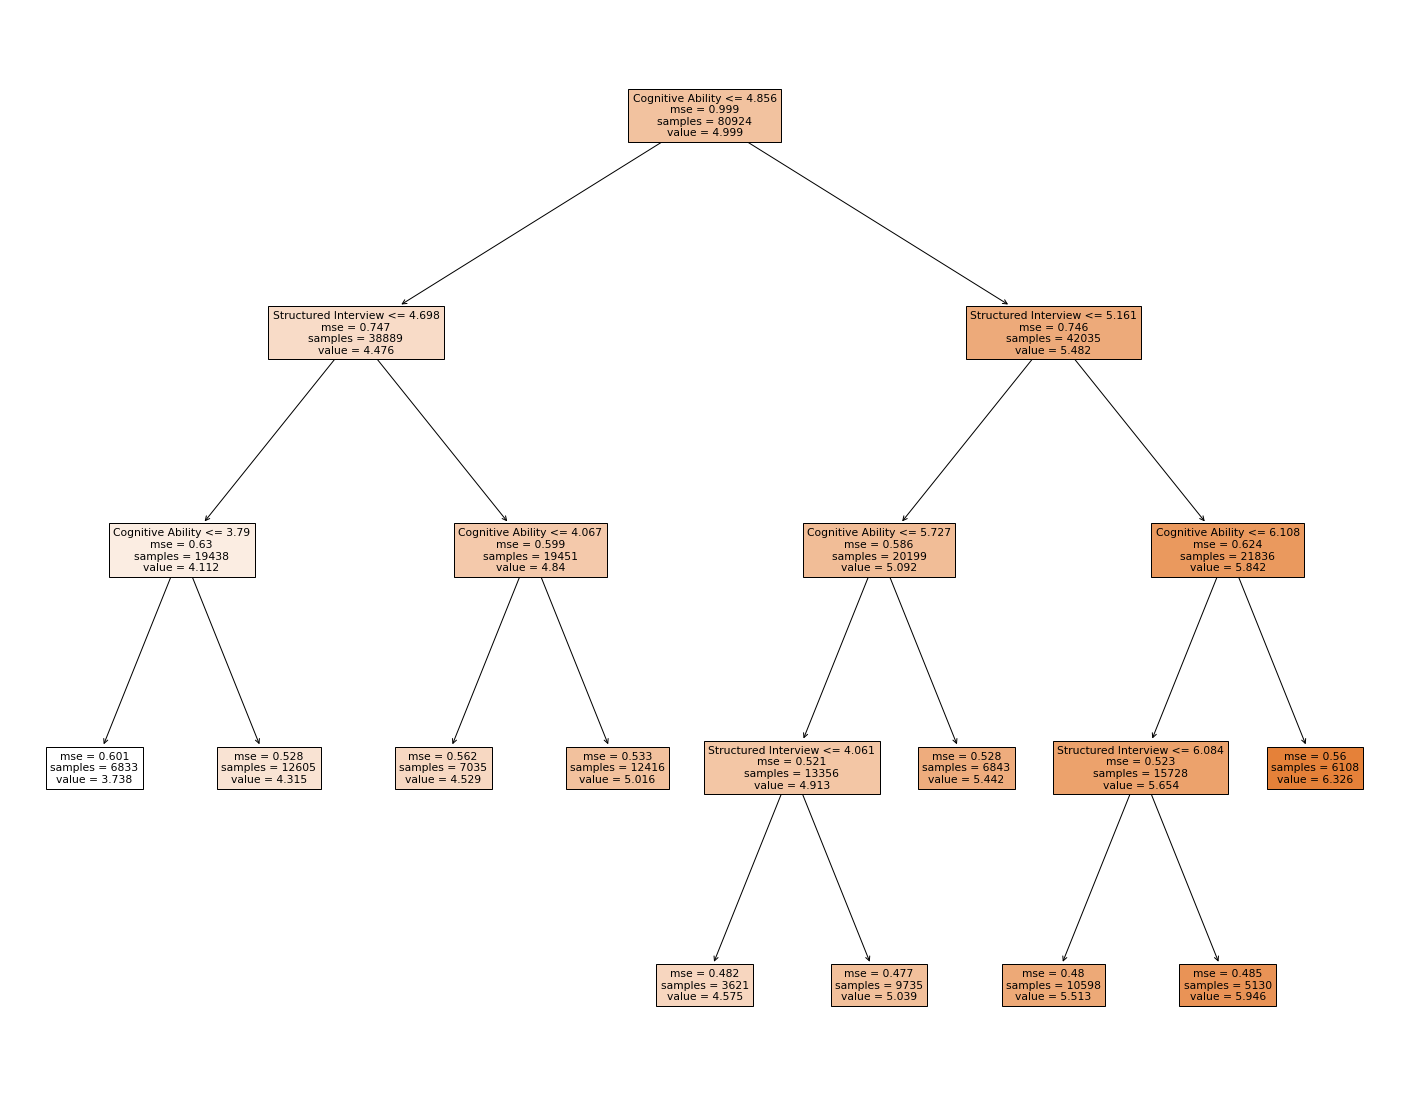

In [180]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt, 
                   feature_names=X_train.loc[:, ~X_train.columns.isin(['group'])].columns,  
                   class_names=['Not Hired','Hired'],
                   filled=True)

This was a disaster. I tried tuning the parameters, but Cognitive Ability is just too strong a predictor. It will always either choose structured interviews or cognitive ability. The f1,impact,and accuracy are all terrible. Out of curiosity I tried running the model without cognitive ability. The accuracy and f1 scores were pretty similar, but the impact ratio was much lower. This is not super relevant though because the decision tree performance was so poor.

In [ ]:
eval_df = X_test
#X_test = sm.add_constant(X_test)
for i in ratios:
    eval_df = X_test[['const','Education','Experience','Structured Interview','Conscientiousness','group']]
    #dt = DecisionTreeClassifier(max_depth=10, max_leaf_nodes =10, max_features=5).fit(X_train.loc[:, ~X_train.columns.isin(['group','Cognitive Ability'])], y_train_eval['Performance']>=1-i)
    dt = DecisionTreeRegressor(max_depth=10, max_leaf_nodes =10).fit(X_train.loc[:, ~X_train.columns.isin(['group','Cognitive Ability'])], y_train)
    #eval_df['pred_val'] =pd.DataFrame(dt.predict_proba(eval_df.loc[:, ~eval_df.columns.isin(['group','Cognitive Ability'])]))[1]
    #eval_df['pct_rank'] = eval_df['pred_val'].rank(pct=True)
    eval_df['pred_val'] =dt.predict(eval_df.loc[:, ~eval_df.columns.isin(['group'])])
    eval_df['pct_rank'] = eval_df['pred_val'].rank(pct=True)
    
    dt_e = evaluate(eval_df,'pct_rank', selection_ratio=i)

    #fig = plt.figure(figsize=(25,20))
    #_ = tree.plot_tree(dt, 
    #               feature_names=X_train.loc[:, ~X_train.columns.isin(['group'])].columns,  
    #               class_names=['Not Hired','Hired'],
    #               filled=True)
    print(str(i),'selection ratio: ','Accuracy: ',round(dt_e[3],2),'F1 score: ',round(dt_e[4],2),'Impact ratio: ',round(dt_e[2],2))

### Ada Boost
Since decision trees went so poorly, I wanted to try Adaboosting. This should obviously lead to higher f1 and accuracy scores on the test data, but I believe this could result in lower impact ratios. Because after initally fitting the majority, the high performing black population should be where the model fits poorly, and therefore Adaboost should focus later models on that portion of data.

First, we'll do some tuning on learning rate and number of learners.

In [221]:
lr_li = []
rat_li = []
acc_li = []
f1_li_li = []
impact_li = []
eval_df = X_test
#X_test = sm.add_constant(X_test)
for i in ratios:
    for ii in np.arange(0.05, 3.05, 0.05):
        eval_df = X_test[['const','Cognitive Ability','Education','Experience','Structured Interview','Conscientiousness','group']]
        dt = AdaBoostRegressor(learning_rate=ii,random_state=1).fit(X_train.loc[:, ~X_train.columns.isin(['group'])], y_train)
        eval_df['pred_val'] =dt.predict(eval_df.loc[:, ~eval_df.columns.isin(['group'])])
        eval_df['pct_rank'] = eval_df['pred_val'].rank(pct=True)

        e = evaluate(eval_df,'pct_rank', selection_ratio=i)
        lr_li.append(ii)
        rat_li.append(i)
        acc_li.append(round(e[3],2))
        f1_li_li.append(round(e[4],2))
        impact_li.append(round(e[2],2))
        #print(str(i),'selection ratio: ','Accuracy: ',round(e[3],2),'F1 score: ',round(e[4],2),'Impact ratio: ',round(e[2],2))

In [222]:
learning_ada = pd.DataFrame({'learning rate':lr_li,'selection ratio':rat_li,'test accuracy':acc_li,'test f1':f1_li_li,'test impact ratio':impact_li})

In [223]:
learning_ada.set_index('learning rate', inplace=True)

selection ratio
0.05    AxesSubplot(0.125,0.125;0.775x0.755)
0.10    AxesSubplot(0.125,0.125;0.775x0.755)
0.30    AxesSubplot(0.125,0.125;0.775x0.755)
0.50    AxesSubplot(0.125,0.125;0.775x0.755)
0.80    AxesSubplot(0.125,0.125;0.775x0.755)
Name: test accuracy, dtype: object

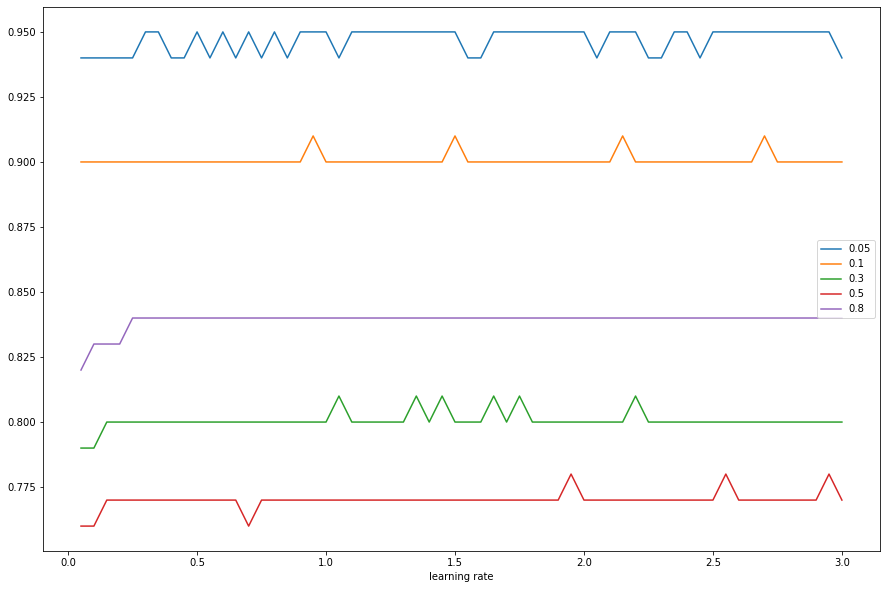

In [224]:
fig = plt.figure(figsize=(15,10))
learning_ada.groupby('selection ratio')['test accuracy'].plot(legend=True)

selection ratio
0.05    AxesSubplot(0.125,0.125;0.775x0.755)
0.10    AxesSubplot(0.125,0.125;0.775x0.755)
0.30    AxesSubplot(0.125,0.125;0.775x0.755)
0.50    AxesSubplot(0.125,0.125;0.775x0.755)
0.80    AxesSubplot(0.125,0.125;0.775x0.755)
Name: test f1, dtype: object

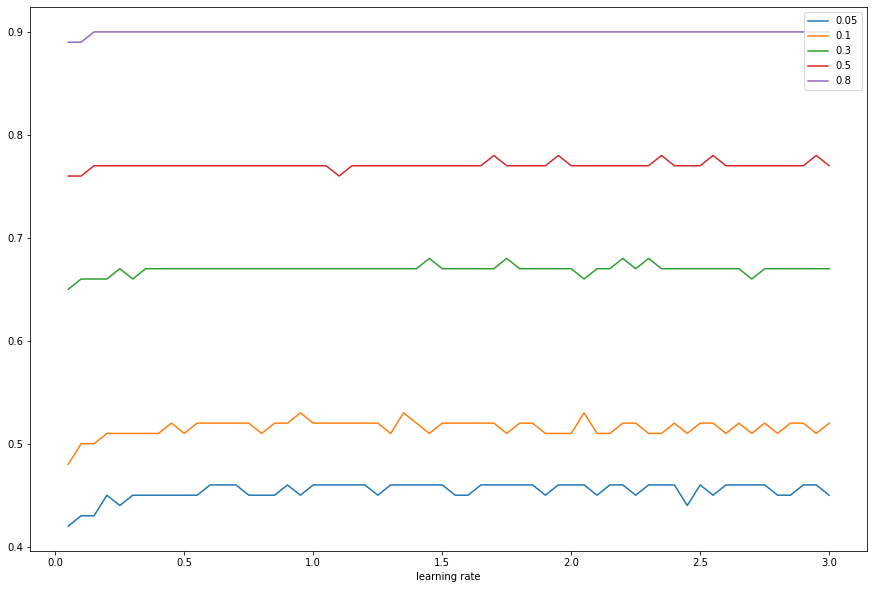

In [225]:
fig = plt.figure(figsize=(15,10))
learning_ada.groupby('selection ratio')['test f1'].plot(legend=True)

selection ratio
0.05    AxesSubplot(0.125,0.125;0.775x0.755)
0.10    AxesSubplot(0.125,0.125;0.775x0.755)
0.30    AxesSubplot(0.125,0.125;0.775x0.755)
0.50    AxesSubplot(0.125,0.125;0.775x0.755)
0.80    AxesSubplot(0.125,0.125;0.775x0.755)
Name: test impact ratio, dtype: object

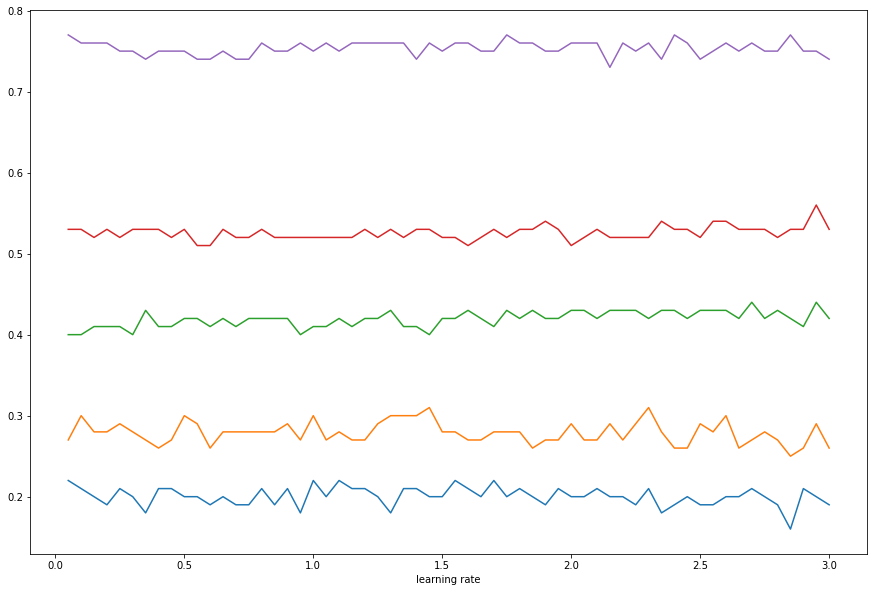

In [226]:
fig = plt.figure(figsize=(15,10))
learning_ada.groupby('selection ratio')['test impact ratio'].plot()

Setting learning rate at .4, impact ratio not affected by learning rate which makes sense. Models with high selection ratios seem to work better with lower learning rates. .4 looks like it performs well for all selection ratios.

In [235]:
#learnerN=[10,40,100,150,300,800,1500,3000]

wk_li = []
rat_li = []
acc_li = []
f1_li_li = []
impact_li = []
eval_df = X_test
#X_test = sm.add_constant(X_test)
for i in ratios:
    print(i)
    for ii in range(5, 205, 10):
        eval_df = X_test[['const','Cognitive Ability','Education','Experience','Structured Interview','Conscientiousness','group']]
        dt = AdaBoostRegressor(learning_rate=.4, random_state=1, n_estimators=ii).fit(X_train.loc[:, ~X_train.columns.isin(['group'])], y_train)
        eval_df['pred_val'] =dt.predict(eval_df.loc[:, ~eval_df.columns.isin(['group'])])
        eval_df['pct_rank'] = eval_df['pred_val'].rank(pct=True)

        e = evaluate(eval_df,'pct_rank', selection_ratio=i)

        wk_li.append(ii)
        rat_li.append(i)
        acc_li.append(round(e[3],2))
        f1_li_li.append(round(e[4],2))
        impact_li.append(round(e[2],2))
        #print(str(i),'selection ratio: ','Accuracy: ',round(e[3],2),'F1 score: ',round(e[4],2),'Impact ratio: ',round(e[2],2))

0.05
0.1
0.3
0.5
0.8


In [236]:
learning_ada = pd.DataFrame({'weak learners':wk_li,'selection ratio':rat_li,'test accuracy':acc_li,'test f1':f1_li_li,'test impact ratio':impact_li})

In [237]:
learning_ada.set_index('weak learners', inplace=True)

selection ratio
0.05    AxesSubplot(0.125,0.125;0.775x0.755)
0.10    AxesSubplot(0.125,0.125;0.775x0.755)
0.30    AxesSubplot(0.125,0.125;0.775x0.755)
0.50    AxesSubplot(0.125,0.125;0.775x0.755)
0.80    AxesSubplot(0.125,0.125;0.775x0.755)
Name: test accuracy, dtype: object

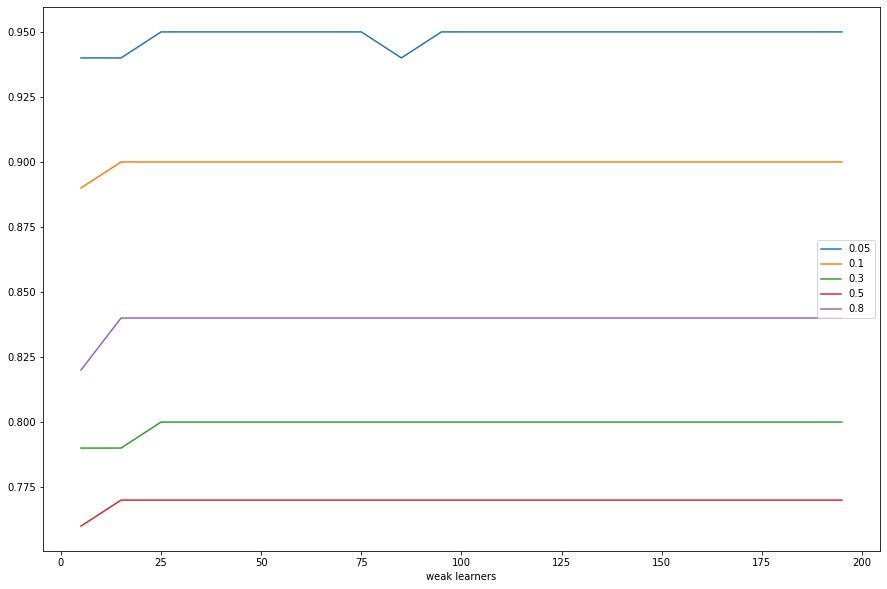

In [238]:
fig = plt.figure(figsize=(15,10))
learning_ada.groupby('selection ratio')['test accuracy'].plot(legend=True)

selection ratio
0.05    AxesSubplot(0.125,0.125;0.775x0.755)
0.10    AxesSubplot(0.125,0.125;0.775x0.755)
0.30    AxesSubplot(0.125,0.125;0.775x0.755)
0.50    AxesSubplot(0.125,0.125;0.775x0.755)
0.80    AxesSubplot(0.125,0.125;0.775x0.755)
Name: test f1, dtype: object

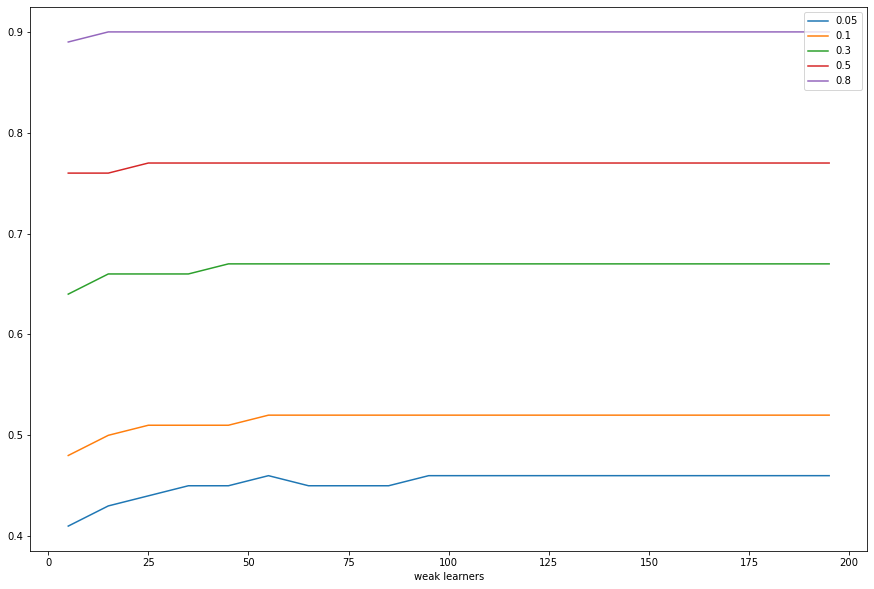

In [239]:
fig = plt.figure(figsize=(15,10))
learning_ada.groupby('selection ratio')['test f1'].plot(legend=True)

selection ratio
0.05    AxesSubplot(0.125,0.125;0.775x0.755)
0.10    AxesSubplot(0.125,0.125;0.775x0.755)
0.30    AxesSubplot(0.125,0.125;0.775x0.755)
0.50    AxesSubplot(0.125,0.125;0.775x0.755)
0.80    AxesSubplot(0.125,0.125;0.775x0.755)
Name: test impact ratio, dtype: object

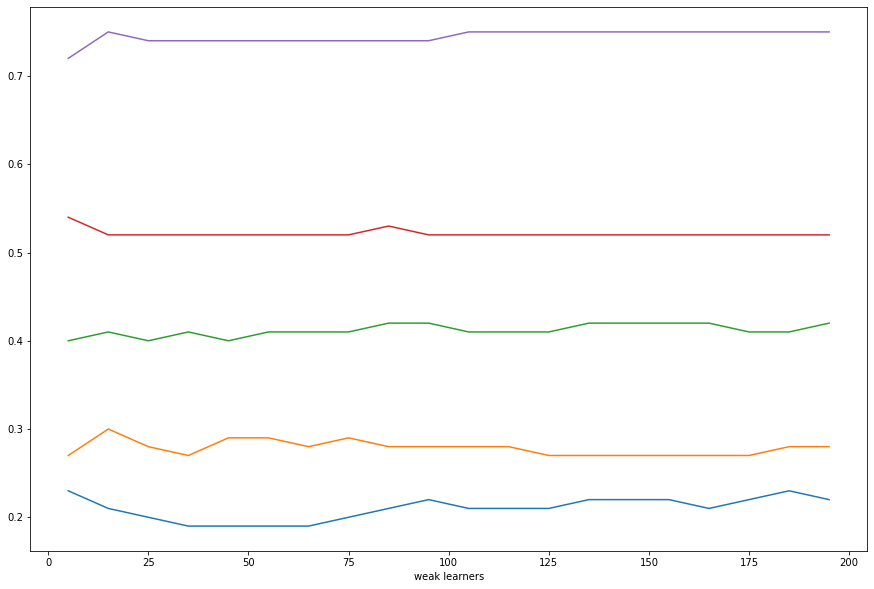

In [240]:
fig = plt.figure(figsize=(15,10))
learning_ada.groupby('selection ratio')['test impact ratio'].plot()

Setting n_estimators to use 100 learners. While most models look like they could use much fewer, the f1 score for the 5% selection rate does not peak until arount 100. Since I'm aiming to set parameters that fit well for all models, we'll use 100 learners. Now we run the final tuned model.

In [327]:
ada_models = []
for i in ratios:
    eval_df = X_test[['const','Cognitive Ability','Education','Experience','Structured Interview','Conscientiousness','group']]
    dt = AdaBoostRegressor(learning_rate=.4, random_state=1, n_estimators=100).fit(X_train.loc[:, ~X_train.columns.isin(['group'])], y_train)
    eval_df['pred_val'] =dt.predict(eval_df.loc[:, ~eval_df.columns.isin(['group'])])
    eval_df['pct_rank'] = eval_df['pred_val'].rank(pct=True)

    e = evaluate(eval_df,'pct_rank', selection_ratio=i)
    ada_models.append(e[:5])

    print(str(i),'selection ratio: ','Accuracy: ',round(e[3],2),'F1 score: ',round(e[4],2),'Impact ratio: ',round(e[2],2))

0.05 selection ratio:  Accuracy:  0.95 F1 score:  0.46 Impact ratio:  0.21
0.1 selection ratio:  Accuracy:  0.9 F1 score:  0.52 Impact ratio:  0.27
0.3 selection ratio:  Accuracy:  0.8 F1 score:  0.67 Impact ratio:  0.41
0.5 selection ratio:  Accuracy:  0.77 F1 score:  0.77 Impact ratio:  0.52
0.8 selection ratio:  Accuracy:  0.84 F1 score:  0.9 Impact ratio:  0.74


In [328]:
ada_models = pd.DataFrame(ada_models,columns=['Minority Selection Rate','Minority Selection Rate','Impact Ratio','Accuracy','F1 Score'])
ada_models['Selection Ratio'] = ratios
ada_models['Method'] = 'Ada Boost'

I'm pretty disappointed in the performance here, it performs almost identically to the multiple regression model. Further, the impact ratios are terrible. I'm going to try one last technique- randomforest. Hopefully if I only train on a subset of the estimators so Cognitive Ability cannot always be choosen, we'll see lower impact ratios because other estimators are contributing.

### Random Forest
My initial settings set max_features to 3. I don't want to go higher than this beacuse I do not want Cognitive ABility in every model.

In [244]:
for i in ratios:
    eval_df = X_test[['const','Cognitive Ability','Education','Experience','Structured Interview','Conscientiousness','group']]
    dt = RandomForestRegressor(max_features=3, random_state=1, n_estimators=100).fit(X_train.loc[:, ~X_train.columns.isin(['group'])], y_train)
    eval_df['pred_val'] =dt.predict(eval_df.loc[:, ~eval_df.columns.isin(['group'])])
    eval_df['pct_rank'] = eval_df['pred_val'].rank(pct=True)

    e = evaluate(eval_df,'pct_rank', selection_ratio=i)

    print(str(i),'selection ratio: ','Accuracy: ',round(e[3],2),'F1 score: ',round(e[4],2),'Impact ratio: ',round(e[2],2))

0.05 selection ratio:  Accuracy:  0.95 F1 score:  0.47 Impact ratio:  0.2
0.1 selection ratio:  Accuracy:  0.91 F1 score:  0.53 Impact ratio:  0.29
0.3 selection ratio:  Accuracy:  0.81 F1 score:  0.68 Impact ratio:  0.44
0.5 selection ratio:  Accuracy:  0.78 F1 score:  0.78 Impact ratio:  0.55
0.8 selection ratio:  Accuracy:  0.84 F1 score:  0.9 Impact ratio:  0.75


The baseline model does not provide a lot of hope, while performance is just about equal to the adaboost and multiple regression models the impact ratios are very slightly better. Now we'll tune the number of learners, to see if we can get a little better performance.

In [257]:
#learnerN=[10,40,100,150,300,800,1500,3000,5000,10000]

wk_li = []
rat_li = []
acc_li = []
f1_li_li = []
impact_li = []
eval_df = X_test
#X_test = sm.add_constant(X_test)
for i in ratios:
    print(i)
    for ii in range(10,510,50):
        eval_df = X_test[['const','Cognitive Ability','Education','Experience','Structured Interview','Conscientiousness','group']]
        dt = RandomForestRegressor(max_features=3, random_state=1, n_estimators=ii).fit(X_train.loc[:, ~X_train.columns.isin(['group'])], y_train)
        eval_df['pred_val'] =dt.predict(eval_df.loc[:, ~eval_df.columns.isin(['group'])])
        eval_df['pct_rank'] = eval_df['pred_val'].rank(pct=True)

        e = evaluate(eval_df,'pct_rank', selection_ratio=i)

        wk_li.append(ii)
        rat_li.append(i)
        acc_li.append(round(e[3],2))
        f1_li_li.append(round(e[4],2))
        impact_li.append(round(e[2],2))
        #print(str(i),'selection ratio: ','Accuracy: ',round(e[3],2),'F1 score: ',round(e[4],2),'Impact ratio: ',round(e[2],2))

0.05
0.1
0.3
0.5
0.8


In [258]:
learning_ada = pd.DataFrame({'weak learners':wk_li,'selection ratio':rat_li,'test accuracy':acc_li,'test f1':f1_li_li,'test impact ratio':impact_li})

In [259]:
learning_ada.set_index('weak learners', inplace=True)

selection ratio
0.05    AxesSubplot(0.125,0.125;0.775x0.755)
0.10    AxesSubplot(0.125,0.125;0.775x0.755)
0.30    AxesSubplot(0.125,0.125;0.775x0.755)
0.50    AxesSubplot(0.125,0.125;0.775x0.755)
0.80    AxesSubplot(0.125,0.125;0.775x0.755)
Name: test accuracy, dtype: object

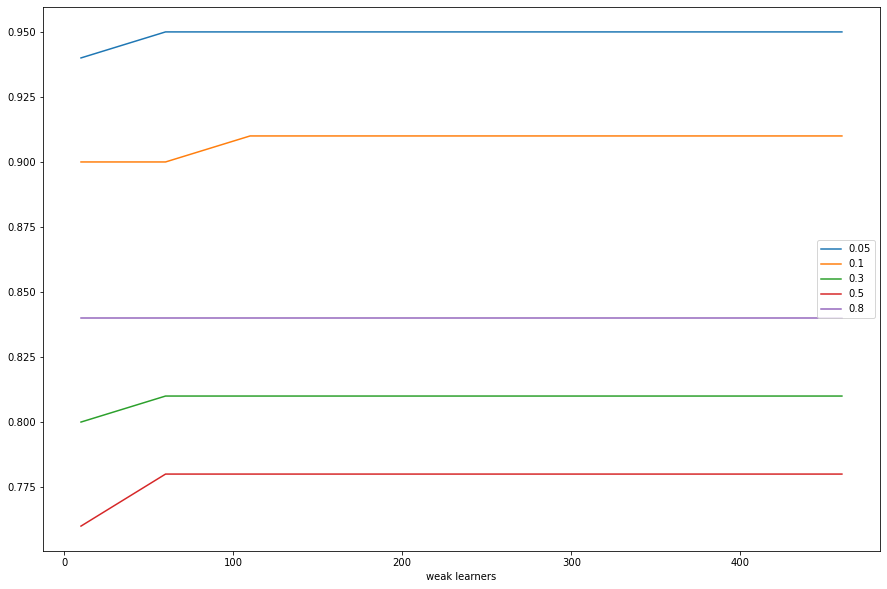

In [260]:
fig = plt.figure(figsize=(15,10))
learning_ada.groupby('selection ratio')['test accuracy'].plot(legend=True)

selection ratio
0.05    AxesSubplot(0.125,0.125;0.775x0.755)
0.10    AxesSubplot(0.125,0.125;0.775x0.755)
0.30    AxesSubplot(0.125,0.125;0.775x0.755)
0.50    AxesSubplot(0.125,0.125;0.775x0.755)
0.80    AxesSubplot(0.125,0.125;0.775x0.755)
Name: test f1, dtype: object

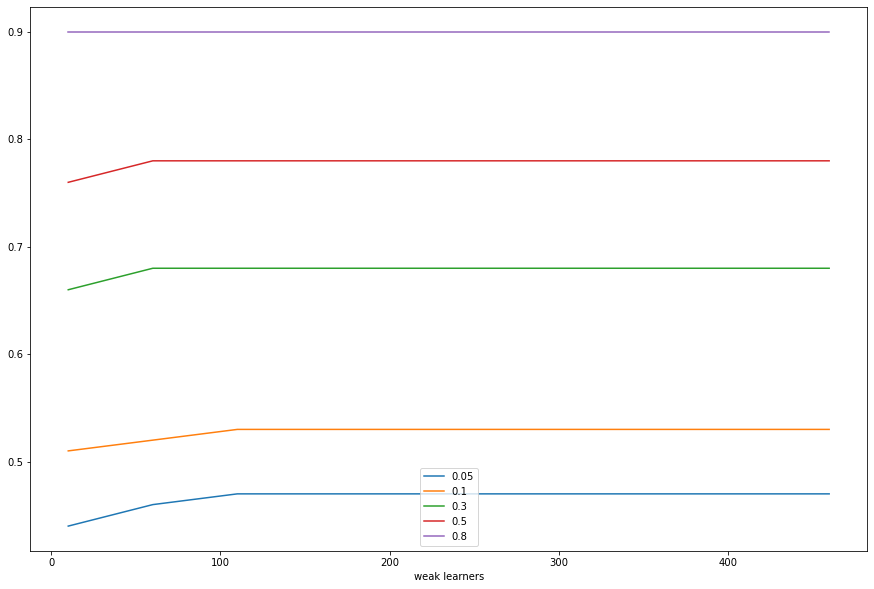

In [261]:
fig = plt.figure(figsize=(15,10))
learning_ada.groupby('selection ratio')['test f1'].plot(legend=True)

selection ratio
0.05    AxesSubplot(0.125,0.125;0.775x0.755)
0.10    AxesSubplot(0.125,0.125;0.775x0.755)
0.30    AxesSubplot(0.125,0.125;0.775x0.755)
0.50    AxesSubplot(0.125,0.125;0.775x0.755)
0.80    AxesSubplot(0.125,0.125;0.775x0.755)
Name: test impact ratio, dtype: object

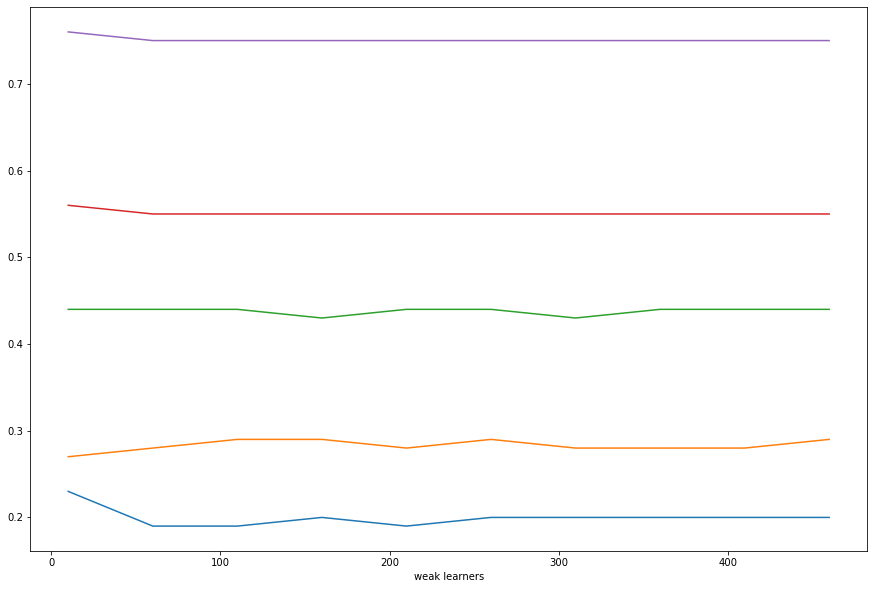

In [262]:
fig = plt.figure(figsize=(15,10))
learning_ada.groupby('selection ratio')['test impact ratio'].plot()

In [ ]:
#setting the number of learners at 130

In [266]:
wk_li = []
rat_li = []
acc_li = []
f1_li_li = []
impact_li = []
eval_df = X_test
#X_test = sm.add_constant(X_test)
for i in ratios:
    print(i)
    for ii in range(1,6):
        eval_df = X_test[['const','Cognitive Ability','Education','Experience','Structured Interview','Conscientiousness','group']]
        dt = RandomForestRegressor(max_features=ii, random_state=1, n_estimators=130).fit(X_train.loc[:, ~X_train.columns.isin(['group'])], y_train)
        eval_df['pred_val'] =dt.predict(eval_df.loc[:, ~eval_df.columns.isin(['group'])])
        eval_df['pct_rank'] = eval_df['pred_val'].rank(pct=True)

        e = evaluate(eval_df,'pct_rank', selection_ratio=i)

        wk_li.append(ii)
        rat_li.append(i)
        acc_li.append(round(e[3],2))
        f1_li_li.append(round(e[4],2))
        impact_li.append(round(e[2],2))
        #print(str(i),'selection ratio: ','Accuracy: ',round(e[3],2),'F1 score: ',round(e[4],2),'Impact ratio: ',round(e[2],2))

0.05
0.1
0.3
0.5
0.8


In [267]:
learning_ada = pd.DataFrame({'weak learners':wk_li,'selection ratio':rat_li,'test accuracy':acc_li,'test f1':f1_li_li,'test impact ratio':impact_li})

In [268]:
learning_ada.set_index('weak learners', inplace=True)

selection ratio
0.05    AxesSubplot(0.125,0.125;0.775x0.755)
0.10    AxesSubplot(0.125,0.125;0.775x0.755)
0.30    AxesSubplot(0.125,0.125;0.775x0.755)
0.50    AxesSubplot(0.125,0.125;0.775x0.755)
0.80    AxesSubplot(0.125,0.125;0.775x0.755)
Name: test accuracy, dtype: object

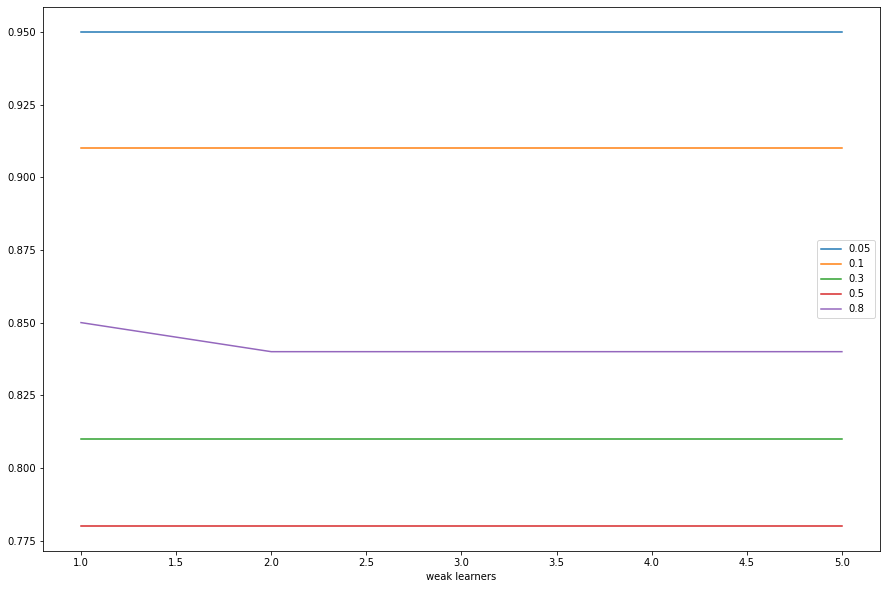

In [269]:
fig = plt.figure(figsize=(15,10))
learning_ada.groupby('selection ratio')['test accuracy'].plot(legend=True)

selection ratio
0.05    AxesSubplot(0.125,0.125;0.775x0.755)
0.10    AxesSubplot(0.125,0.125;0.775x0.755)
0.30    AxesSubplot(0.125,0.125;0.775x0.755)
0.50    AxesSubplot(0.125,0.125;0.775x0.755)
0.80    AxesSubplot(0.125,0.125;0.775x0.755)
Name: test f1, dtype: object

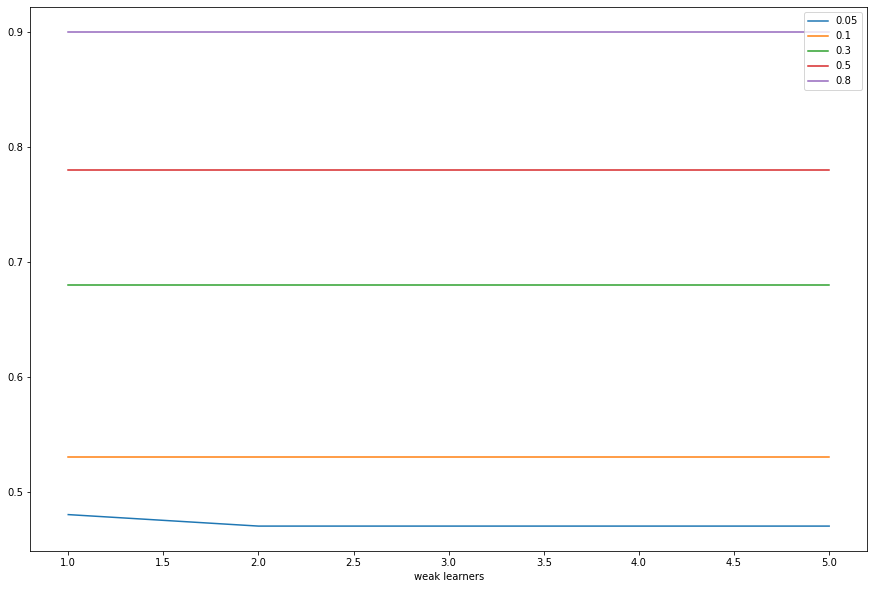

In [270]:
fig = plt.figure(figsize=(15,10))
learning_ada.groupby('selection ratio')['test f1'].plot(legend=True)

selection ratio
0.05    AxesSubplot(0.125,0.125;0.775x0.755)
0.10    AxesSubplot(0.125,0.125;0.775x0.755)
0.30    AxesSubplot(0.125,0.125;0.775x0.755)
0.50    AxesSubplot(0.125,0.125;0.775x0.755)
0.80    AxesSubplot(0.125,0.125;0.775x0.755)
Name: test impact ratio, dtype: object

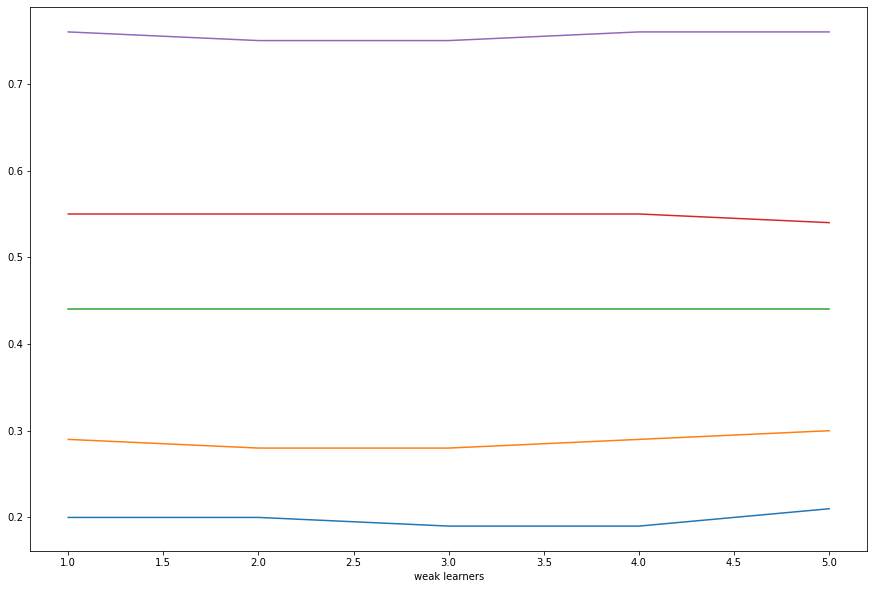

In [271]:
fig = plt.figure(figsize=(15,10))
learning_ada.groupby('selection ratio')['test impact ratio'].plot()

In [ ]:
#final model

In [321]:
rf_models = []
for i in ratios:
    eval_df = X_test[['const','Cognitive Ability','Education','Experience','Structured Interview','Conscientiousness','group']]
    dt = RandomForestRegressor(max_features=1, random_state=1, n_estimators=130).fit(X_train.loc[:, ~X_train.columns.isin(['group'])], y_train)
    eval_df['pred_val'] =dt.predict(eval_df.loc[:, ~eval_df.columns.isin(['group'])])
    eval_df['pct_rank'] = eval_df['pred_val'].rank(pct=True)

    e = evaluate(eval_df,'pct_rank', selection_ratio=i)
    rf_models.append(e[:5])
    print(str(i),'selection ratio: ','Accuracy: ',round(e[3],2),'F1 score: ',round(e[4],2),'Impact ratio: ',round(e[2],2))

0.05 selection ratio:  Accuracy:  0.95 F1 score:  0.48 Impact ratio:  0.2
0.1 selection ratio:  Accuracy:  0.91 F1 score:  0.53 Impact ratio:  0.29
0.3 selection ratio:  Accuracy:  0.81 F1 score:  0.68 Impact ratio:  0.44
0.5 selection ratio:  Accuracy:  0.78 F1 score:  0.78 Impact ratio:  0.55
0.8 selection ratio:  Accuracy:  0.85 F1 score:  0.9 Impact ratio:  0.76


In [322]:
rf_models = pd.DataFrame(rf_models,columns=['Minority Selection Rate','Minority Selection Rate','Impact Ratio','Accuracy','F1 Score'])
rf_models['Selection Ratio'] = ratios
rf_models['Method'] = 'Random Forest'

## Results
Let's look at our 3 primary performance metrics by method.

In [349]:
final = reg_models.append(rf_models).append(dt_models).append(ada_models)

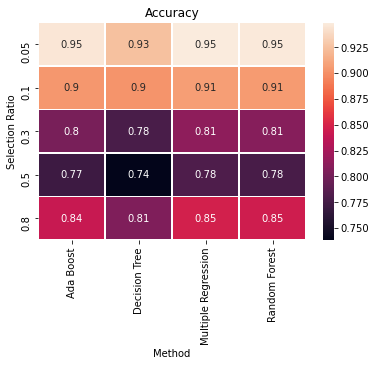

In [360]:
ax = plt.axes()
sn.heatmap(final.pivot("Selection Ratio", "Method", "Accuracy"),annot=True,linewidths=.5,ax = ax)
ax.set_title('Accuracy')
plt.show()

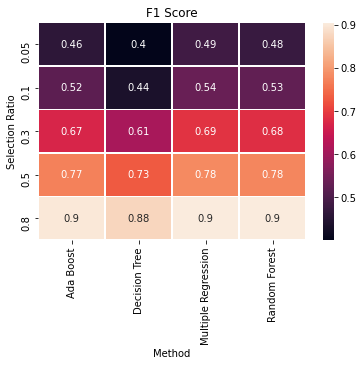

In [361]:
ax = plt.axes()
sn.heatmap(final.pivot("Selection Ratio", "Method", "F1 Score"),annot=True,linewidths=.5,ax = ax)
ax.set_title('F1 Score')
plt.show()

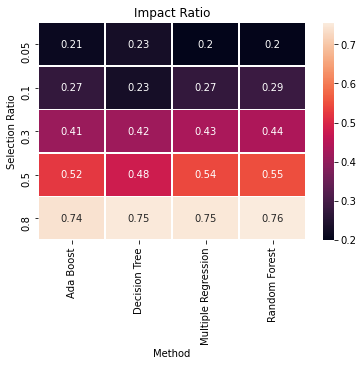

In [362]:
ax = plt.axes()
sn.heatmap(final.pivot("Selection Ratio", "Method", "Impact Ratio"),annot=True,linewidths=.5,ax = ax)
ax.set_title('Impact Ratio')
plt.show()

In the end, none of the non-parametric models consistently out performed the original multiple regression model. Ada boosting and random forest resulted in very similar performing models to the original multiple regression model. All of our models had disparate impact, so as it stands none could be implemented in practice. 

I think the lack of imporvement over multiple regression could have to do with how the dataset was generated. Real data has much more complicated relationships than setting means, standard deviations, and correlations with all of our data being perfrectly normal. Perhaps real world data would have different results.